This notebook explores the implementation of adaptive quantum algorithms using the Tequila library, focusing on variational quantum eigensolvers (VQE).

# Abstract {.unnumbered}

Variational Quantum Algorithms (VQA) is a promising approach to solving problems on near-term quantum computers by combining the simulation capabilities of quantum computers with the optimization capabilities of classical computers. Their performance is highly dependent on the choice of the ansatz, which is the basis for the performance of the algorithm. In this notebook, we explore the implementation of adaptive quantum algorithms in a quantum computer simulator. To ease the prototyping and development of these algorithms, we demonstrate the library Tequila [@tequila21] for the development of quantum algorithms. We then introduce the concept of variational quantum eigensolvers, a popular application of VQA, and an adaptive method to construct a variational structure ansatz. Finally, we implement an example of a more complex VQE using a variable structure ansatz, proposed by Grimsley et al. [@Grimsley:2019aa].


In [1]:
#| echo: false
import tequila as tq
import numpy as np
from math import pi, sqrt
from matplotlib import pyplot as plt
import random
from IPython.display import display, Markdown, Image
import time
import os
import sys

def draw_circuit(circuit, label, caption, width=300):
    filename = f'_build/{label}.png'
    circuit.export_to(filename=filename) 
    display(Markdown(f"![{caption}]({filename}){{#{label} width={width}}}"))
    # display(Markdown(f"{{#{label} width={width}}}"))

# Introduction

## Introduction and general overview of quantum algorithms
In a world where a steadily increasing number of problems can be solved by traditional computers and processors, the limits of traditional processors for specific problems have been becoming more and more apparent.

This especially is the case for problems related to chemistry and quantum physics, simulations require an exponentially scaling amount of computational resources and time to complete.

In the current era of NISQ-scale quantum computers, where no widespread quantum superiority (as in, quantum computers that solve problems faster than a traditional computer) yet exists, but is to be expected - algorithms have to conform to the limitations of the hardware.
An interesting application area for these algorithms is the accurate simulation of the physical and chemical properties of atoms, molecules, and other many-body systems on a quantum level [@review-variational].

## Tequila as a tool for quantum algorithm development

Developing quantum algorithms without a toolset that allows testing them makes for a difficult task, similar to the early era of classical computing that only allowed for programs to be written on punch cards, only being able to debug them after they have been written.

While there are multiple tools and libraries to help with the rapid prototyping of quantum algorithms, we focus this notebook on the library Tequila [@tequila21].

Tequila includes a broad toolset of predefined gates, functions, and utilities which allows us to rapidly test and prototype quantum algorithms.
Additionally, it integrates with multiple other quantum backends, for chemical and physical computations [@tequila21], and includes methods for automatic differentiation.

In the following section, we introduce the basic concepts of Tequila and how it can be used to develop and simulate quantum algorithms.

<!-- TODO: Do we need this? -->
In its toolset, Tequila also includes the Pauli operators, which we will list here for reference:
$$
P(X) = \ket{0}\bra{1} + \ket{1}\bra{0} = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}
$$ {#eq-pauli-x}
$$
P(Y) = -i\ket{0}\bra{1} + i\ket{1}\bra{0} = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix}
$$ {#eq-pauli-y}
$$
P(Z) = \ket{0}\bra{0} - \ket{1}\bra{1}  = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$ {#eq-pauli-z}

### Simulating a simple circuit

<!-- TODO: Add more detailed description of examples executed here -->

As an example, we define a circuit in tequila with a simple Pauli X gate, operating on qubit 0, and simulate it.

In [2]:
circuit = tq.gates.X(target=0)

In [3]:
#| echo: false
#draw_circuit(circuit, 'fig-basic-circuit', 'Basic circuit with a Pauli X gate on qubit 0', width=200) 

![Basic circuit with a Pauli X gate on qubit 0](_build/fig-basic-circuit.png){#fig-basic-circuit width=200}

When we simulate the circuit, the result is the wavefunction that the circuit results in, which in this case, is the probability amplitude of measuring the state $\ket{1}$ on qubit 0.
It is important to note, all qubits are initialized in the 0 state, which means, that the circuit in @fig-basic-circuit essentially flips the state of qubit 0 from $\ket{0}$ to $\ket{1}$.

In [4]:
#| label: sim-output
tq.simulate(circuit)

+1.0000|1> 

Consequently adding another Pauli X gate to the circuit that acts on qubit 0, we can see that the probability of  $\ket{0}$ on qubit 0 is now 0, as all Pauli matrices are unitary and therefore self-inverse.

In [5]:
circuit += tq.gates.X(target=0)

In [6]:
#| echo: false
#draw_circuit(circuit, 'fig-two-x-circuit', 'Basic circuit with two Pauli X gates on qubit 0', width=300)

![Basic circuit with two Pauli X gates on qubit 0](_build/fig-two-x-circuit.png){#fig-two-x-circuit width=300}

In [7]:
tq.simulate(circuit)

+1.0000|0> 

### Multi-qubit circuits

Adding a controlled Pauli X gate, acting on qubit 1 and controlled by qubit 0 (in between the two Pauli X gates), we get the expected result: The state $\ket{01}$ has a probability amplitude of 1.

In [8]:
circuit = tq.gates.X(0) +  tq.gates.X(target=1, control=0) + tq.gates.X(0)

In [9]:
#| echo: false
#draw_circuit(circuit, 'fig-controlled-circuit', 'Circuit with two Pauli X gates on qubit 0 and a controlled Pauli X gate on qubit 1 controlled by qubit 0.', width=300)

![Circuit with two Pauli X gates on qubit 0 and a controlled Pauli X gate on qubit 1 controlled by qubit 0](_build/fig-controlled-circuit.png){#fig-controlled-circuit width=300}

In [10]:
tq.simulate(circuit)

+1.0000|01> 

Now, let us define a more complex circuit, which consists of a Hadamard gate on qubit 0, followed by a CNOT gate with qubit 0 as the control and qubit 1 as the target. This circuit is equivalent to the base change of two qubits to the bell basis. 

In [11]:
circuit = tq.gates.H(target=0) + tq.gates.CNOT(control=0, target=1)

In [12]:
#| echo: false
#draw_circuit(circuit, 'fig-hadamard-cnot-circuit', 'Circuit with a Hadamard gate on qubit 0 and a CNOT gate with qubit 0 as the control and qubit 1 as the target.', width=300)

![Circuit with a Hadamard gate on qubit 0 and a CNOT gate with qubit 0 as the control and qubit 1 as the target](_build/fig-hadamard-cnot-circuit.png){#fig-hadamard-cnot-circuit width=300}

In [13]:
tq.simulate(circuit)

+0.7071|00> +0.7071|11> 

### Parametrized circuits {#sec-parametrized-circuits}

Additionally, we can parametrize the circuits using variables, which are used to parametrize rotation or phase shifts.
The most basic rotations are all based on Pauli matrices. 
With $p \in {X, Y, Z}$, and $\sigma{_p}$ being the corresponding pauli matrix (see @eq-pauli-x), the Pauli rotation around $p$ can be described by:
$$ 
R_p(\Phi) = e^{(-i\frac{\Phi}{2}\sigma{_p})} = \cos(\frac{\Phi}{2}) -i \sin(\frac{\Phi}{2}\sigma{_p})
$$

To further illustrate the Pauli rotations that we will use here, they are listed as matrices in the following:

$$
R_X(\Phi) = \begin{pmatrix} \cos(\frac{\Phi}{2}) & -i\sin(\frac{\Phi}{2}) \\ -i\sin(\frac{\Phi}{2}) & \cos(\frac{\Phi}{2}) \end{pmatrix}
$$ {#eq-pauli-x-rotation}
$$
R_Y(\Phi) = \begin{pmatrix} \cos(\frac{\Phi}{2}) & -\sin(\frac{\Phi}{2}) \\ \sin(\frac{\Phi}{2}) & \cos(\frac{\Phi}{2}) \end{pmatrix}
$$ {#eq-pauli-y-rotation}
$$
R_Z(\Phi) = \begin{pmatrix} e^{-i\frac{\Phi}{2}} & 0 \\ 0 & e^{i\frac{\Phi}{2}} \end{pmatrix}
$$ {#eq-pauli-z-rotation}

Whereas @eq-pauli-x-rotation and @eq-pauli-y-rotation are rotations around the x and y-axis of the Bloch sphere, and @eq-pauli-z-rotation is a phase shift around the z-axis of the Bloch sphere, respectively.

The following example demonstrates this using a Pauli Y rotation based on the variable a.
We set the variable a to $\frac{\pi}{2}$, which results in the Pauli Y rotation which, when adding a Pauli Z gate is equivalent to a Hadamard gate.

In [14]:
circuit = tq.gates.Ry('a', 0) + tq.gates.Z(0)
tq.simulate(circuit, {'a': pi/2})

+0.7071|0> -0.7071|1> 

In [15]:
#| echo: false
#draw_circuit(circuit, 'fig-parametrized-circuit', 'Circuit with a parametrized Y rotation and Z gate on qubit 0.', width=300)

![Circuit with a parametrized Y rotation and Z gate on qubit 0](_build/fig-parametrized-circuit.png){#fig-parametrized-circuit width=300}

## Adaptive methods in quantum algorithms {#sec-adaptive-methods}

In general, most quantum algorithms are based on optimization problems, so-called variational algorithms.
Variational quantum algorithms (VQA) are based on the combination of a quantum circuit, which is parameterized by a set of variables, and a classical optimizer, which is used to find the optimal set of variables for the given problem [@review-variational].

A challenge in the development of variational quantum algorithms is the choice of the quantum circuit, which is used to solve the problem. This circuit is called the ansatz, and it is the basis for the performance of the algorithm. Many different ansatzes have been proposed, including the unitary coupled cluster ansatz, inherent to many-body physics, and the choice of the ansatz itself is based on the problem that is to be solved [@review-variational].

Instead of using a fixed ansatz as a basis for the VQA, it is also possible to construct the circuit ansatz adaptively, based on the optimization problem we work on. We also call this the variable structure ansatz, as the structure of the ansatz is variable and depends on the problem [@review-variational].

# Variational Quantum Eigensolvers (VQE)

## Introduction of VQEs

Before detailing and implementing an adaptive variational quantum algorithm, we first introduce the concept of one of the first variational quantum algorithms, the Variational Quantum Eigensolver (VQE) proposed by @vqe.

As already briefly mentioned in @sec-adaptive-methods, variational quantum algorithms are based on the concept of a combination of the capabilities of a quantum computer, which can simulate quantum states (for example, the ground energy of a molecule), and the capabilities of a classical computer, which can optimize the parameters of a quantum circuit [@review-variational].

Notably, we refer to the QVE (Quantum Variational Eigensolver) in @vqe as VQE, as it is more commonly known as VQE in the literature.

## Implementing a basic VQE {#sec-basic-vqe}

In this section, we will implement a basic VQE using Tequila, which will serve as a basis for the implementation of an adaptive VQE in the next section.
In the following block, we calculate the ground state energy of ${He}_2$, using the fixed structure ansatz `UpCCGSD`, a generalized unitary coupled cluster ansatz, that contains single and double excitations [@review-variational].

In [16]:
geometry = "He 0.0 0.0 0.0\nHe 0.0 0.0 0.5"
molecule = tq.Molecule(geometry=geometry, basis_set='6-31g')
U = molecule.make_upccgsd_ansatz()
H = molecule.make_hamiltonian()
print(f"{U.depth = }")

U.depth = 18


Inspecting the depth of the circuit, we can see that the depth of the circuit is 18. As every additional gate in the circuit introduces more noise, it is important to consider the circuit depth for current quantum computers.

Nonetheless, we can simulate the circuit and calculate the ground state energy of the Helium molecule.

In [17]:
#| echo: false
#draw_circuit(U, 'fig-static-upccgsd-circuit', 'UCCsD Ansatz circuit', width=500)


#tq.draw(U)

![](Helium.png){width=100%}

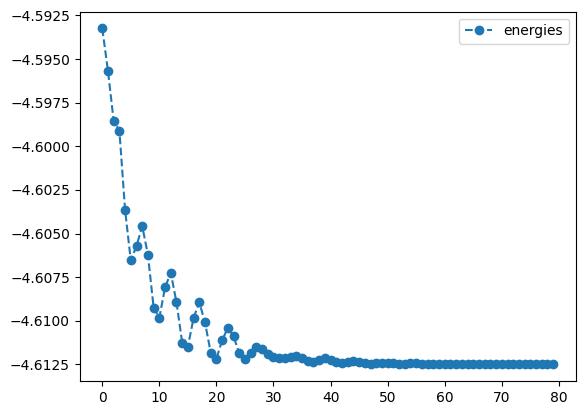

result.energy = -4.612504938737554


In [18]:
E = tq.ExpectationValue(H=H, U=U) #<1>
result = tq.minimize(objective=E, silent=True, method='adam', maxiter=80) #<2>

result.history.plot('energies')
print(f"{result.energy = }")

1. Define the abstract expectation value, that we will use to optimize the circuit.
2. Minimize the expectation value, which results in the optimal parameters for the circuit.

After optimizing the abstract expectation value `E`, simulating the quantum computer computations, and optimizing the parameters of the circuit using the classical optimization method `Adam`, we get our result of the ground state energy, which we can use to evaluate the result of our adaptive VQE in the next section.

# Adaptive circuit construction

## Implementing a basic adaptive VQE

Tequila includes a implementation of an `AdaptiveSolver`, that takes an operator_pool, a pre and post-unitary, as well as a Hamiltonian to minimize.
For illustrative purposes, we will implement our version of an adaptive solver, based on the works of @tequila-adaptive.

As we have mentioned before, the adaptive method is based on the concept of a variable structure ansatz. We construct this ansatz iteratively, in the following simplified steps:

1. Calculate the gradients for all operators in the operator pool.
2. Choose the operator which yields the highest gradient and add it to the circuit.
3. Minimize the abstract expectation value for the updated circuit, optimizing the parameters (see @sec-parametrized-circuits) of the updated circuit [@tequila-adaptive].

The iteration is usually stopped with stopping criteria based on the gradients of the latest iteration falling under a certain defined threshold.
Note that we will explicitly only iterate 4 times, to allow for a clear illustration.


In [19]:
import tequila as tq
import numpy as np

def calculate_gradients(operator_pool, circuit, H, variables):
    """
    calculate gradients for a given circuit and operator pool
    :param operator_pool: list of pauli strings
    :param circuit: tequila circuit
    :param H: tequila hamiltonian
    :param variables: dictionary of variables
    :return: list of gradients
    """

    gradients = []
    for operator in operator_pool:
        if 'screen_angle' in circuit.extract_variables():
            raise Exception("variable screen_angle already exists")
        gate = tq.gates.Rp(paulistring=operator, angle='screen_angle')
        test_circuit = circuit + gate
        E = tq.ExpectationValue(U=test_circuit, H=H)
        objective = tq.grad(E, 'screen_angle')
        # expand our variables with our screen_angle
        new_variables = {**variables}
        new_variables['screen_angle'] = 0.0
        gradient = tq.simulate(objective, variables=new_variables)
        gradients.append(gradient)
    return gradients

Extending the example implementation, we implement a simplified iteration step in the following, that first uses `calculate_gradients` from before to calculate a list of gradients for the operator pool. 
Following the gradient calculation, we choose the operator in the pool with the highest gradient and append the corresponding Pauli rotation `Rp` to the circuit.
Finally, we construct the expectation value for the updated circuit and calculate the new, minimized variable mappings.

In [20]:
def do_iteration(operator_pool, circuit, H, variables, iteration):
    gradients = calculate_gradients(
        operator_pool=operator_pool,
        circuit=circuit,
        H=H,
        variables=variables)
    max_index = np.argmax(np.abs(gradients))

    gate = tq.gates.Rp( # <1>
        paulistring=operator_pool[max_index], # <1>
        angle=f'iter_{iteration}' # <1>
        )

    circuit += gate # <2>

    E = tq.ExpectationValue(U=circuit, H=H)
    result = tq.minimize(E, silent=True) # <3>
    variables.update(result.variables)
    return gradients

1. Create gate with maximum gradient
2. Add gate to circuit
3. Minimize and update the optimize variable values

In the following section, we illustrate an example of the adaptive circuit construction, using the implementation of the iteration and gradient calculation function from before.

## Running example iterations

For initialization, we start with defining an example Hamiltonian and initial circuit, which allows us to show the adaptive circuit construction. Therefore, we will use a simple Hamiltonian, which consists of a linear combination of Pauli strings.

We define our Hamiltonian H that we want to minimize as follows:
$$
H = 2\cdot(X(0) \cdot X(1) + Y(0) \cdot Y(1)) + 10 \cdot (X(3) \cdot X(5) + Y(3) \cdot Y(5))
$$

Additionally, we set up an initial circuit with two Pauli X gates, which will initialize the state with 1 on qubits 0 and 2. This is technically not necessary, as the Pauli rotations can reach this state as well: the rotation with Pauli XY $e^{-i\frac{\Phi}{2}XY}$ with $\Phi = \pi$ also transforms the state $\ket{00}$ to state $\ket{11}$. In the interest of reducing the size of our operator pool, we use the initial state in the following example.

In [21]:
circuit = tq.gates.X(0) + tq.gates.X(3) # <1>
circuit.n_qubits = 6
H = 2*(tq.paulis.X(0) * tq.paulis.X(1) + tq.paulis.Y(0) * tq.paulis.Y(1)) \
    + 10*(tq.paulis.X(3) * tq.paulis.X(5) + tq.paulis.Y(3) * tq.paulis.Y(5)) # <2>

operator_strings = ["X(0)Y(1)", "X(3)Y(5)"] # <3>
operator_pool = [ 
    tq.PauliString.from_string(operator) for operator in operator_strings # <3>
    ] # <3>

variables = {}
circuits = []
gradients = []
energies = []


M = H.to_matrix() # <4>
eigen_values, eigen_vectors = np.linalg.eigh(M)
energy_0 = eigen_values[0]
print(f"{energy_0 = }")
wfn_0 = tq.QubitWaveFunction(eigen_vectors[:,0])

energy_0 = -24.000000000000007


1. Define circuit
2. Define Hamiltonian H
3. Define operator pool
4. Calculate eigenvalues and eigenvectors of H, to calculate the ground state energy of the system.

Notably, as this is a simple Hamiltonian we can calculate its ground state energy, to compare it to the result of our implementation.
As we show over four iterations, the resulting energy converges to the previously calculated ground state energy.
Before iterating, we have a look at the initial state: The circuit has no parametrized gates yet, so the optimizer is yet unable to minimize any values.


In [22]:
E = tq.ExpectationValue(U=circuit, H=H)

result = tq.minimize(E, silent=True)
print(f"{result.energy = }")

result.energy = 0.0


In [23]:
#| echo: false
from copy import deepcopy
circuits.append(deepcopy(circuit))

Finally, the following code block performs 4 iterations of the adaptive solving we implemented above.

In [24]:
for i in range(4):
    last_gradients = do_iteration(operator_pool, circuit, H, variables, i)

    gradients.append(np.linalg.norm(last_gradients))
    circuits.append(deepcopy(circuit))

    E = tq.ExpectationValue(U=circuit, H=H)
    result = tq.minimize(E, silent=True)
    energies.append(result.energy)

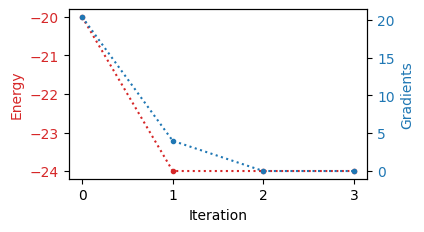

In [25]:
#| echo: false
#| label: fig-plot-energy-and-gradient 
#| fig-cap: "Energies and gradients over iterations"

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
# make sure iteration is always integer
ax1.set_xticks([i for i in range(len(energies))])
ax1.set_ylabel('Energy', color=color)
ax1.plot(energies, color=color, marker='.', linestyle='dotted')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Gradients', color=color)  # we already handled the x-label with ax1
ax2.plot(gradients, color=color, marker='.', linestyle='dotted')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_figwidth(4)
fig.set_figheight(2)
plt.show()

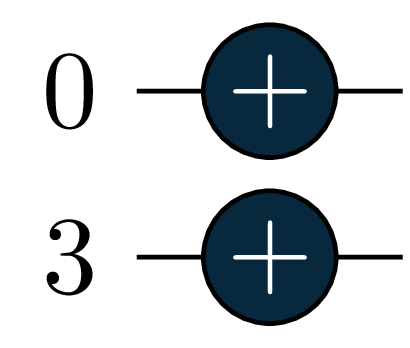

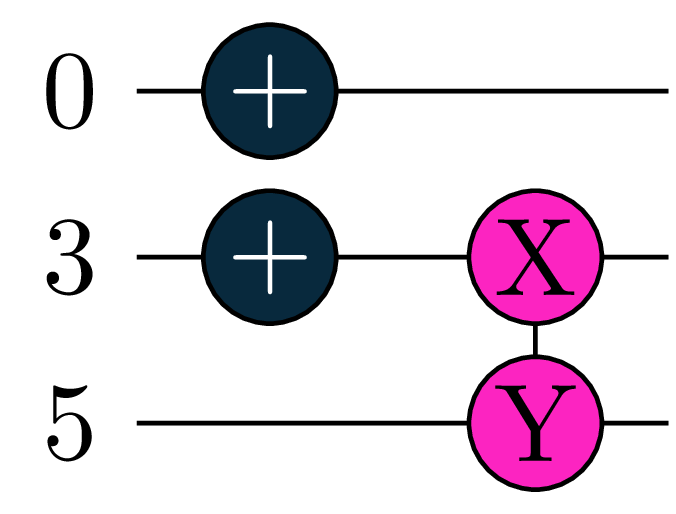

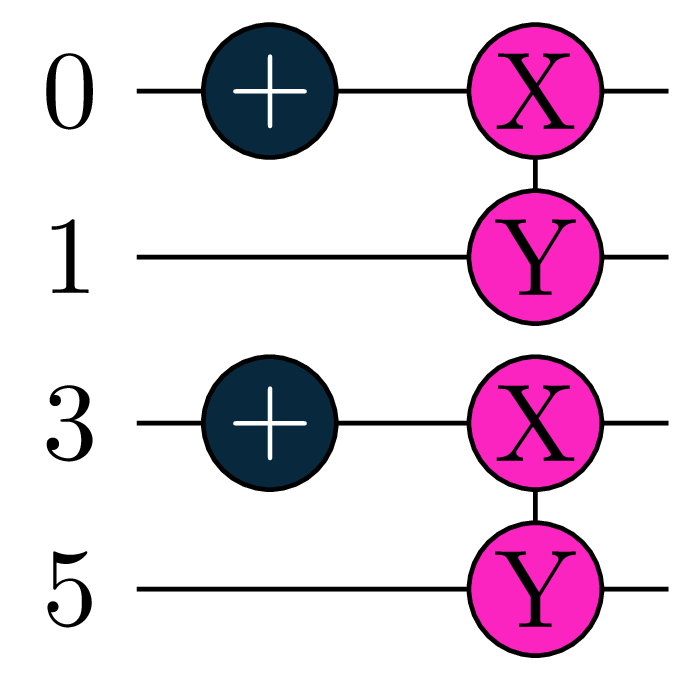

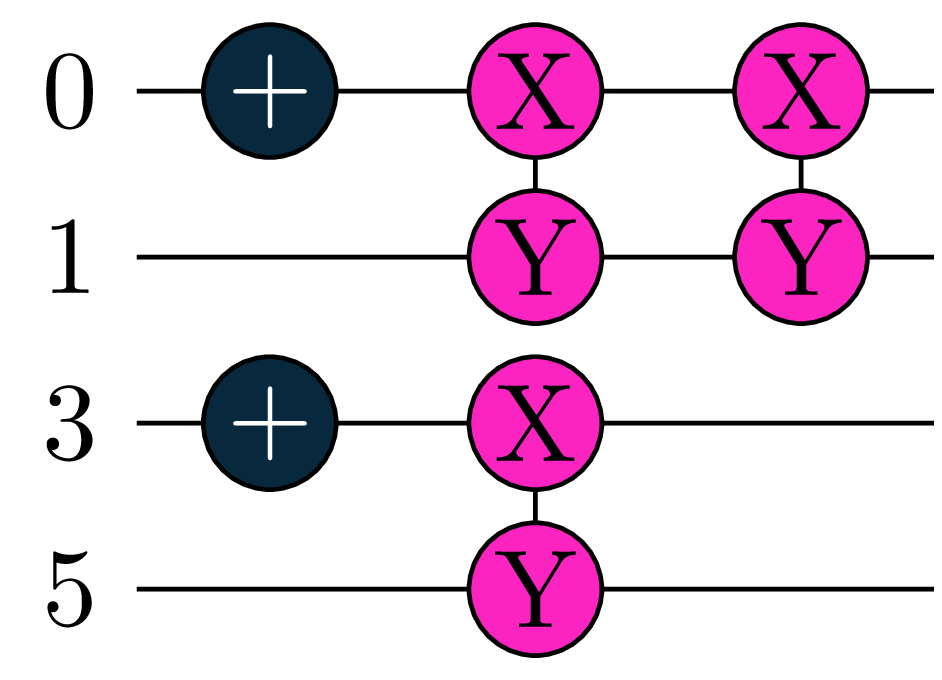

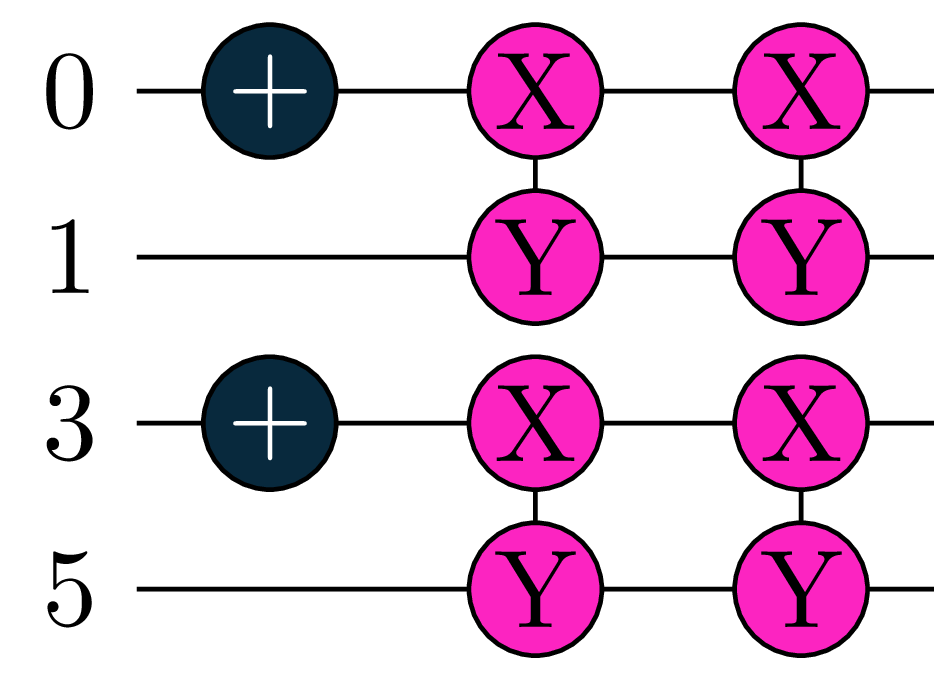

In [33]:
#| echo: false
#| label: fig-adapt-circuits
#| fig-cap: "Basic adaptive circuit after iterations"
#| fig-subcap:
#|   - "Initial circuit"
#|   - "Iteration 1"
#|   - "Iteration 2"
#|   - "Iteration 3"
#|   - "Iteration 4"
#| layout-ncol: 5
#| layout-valign: bottom 

out = sys.stdout
sys.stdout = open(os.devnull, 'w')

for i, circuit in enumerate(circuits):
    filename = f'_build/adaptive_circuit_{i}.png'
    circuit.n_qubits = 6
    circuit.export_to(filename=filename) 
    display(Image(filename, width=100))

sys.stdout = out

Inspecting the energies and gradients in @fig-plot-energy-and-gradient, we see that the adaptively constructed circuit in this example allows the optimization to converge close to our target energy $E_0 \approx -24$.
The gradients are highest in the first iteration, as we greedily choose the highest gradient available.
Furthermore, @fig-adapt-circuits illustrates the iterative construction of the circuit, where each iteration step, adds one rotation from the operator pool.

## Application of ADAPT-VQE in Tequila {#sec-adapt-vqe}

Following the example implementation of an adaptive solver, we will apply this concept to an adaptive VQE, using the implementation provided by the Tequila library [@tequila21]. 
Like in @sec-basic-vqe, we will first create a Helium atom, of which we want to find the ground state energy.
Moreover, we will use the utility of Tequila to infer the Hamiltonian that represents the energy of a Helium molecule.

In [27]:
geometry = "He 0.0 0.0 0.0\nHe 0.0 0.0 0.5"
molecule = tq.Molecule(geometry=geometry, basis_set='6-31g')
H = molecule.make_hamiltonian()

Subsequently, we would define the ansatz that we use as starting point to optimize its parameters.
In contrast to the implementation with a fixed ansatz, we will proceed to use the adaptive solver to construct the variable structure ansatz. 
For this, we first use Tequila's `MolecularPool`, to infer the operators that we use to construct the ansatz. It is important to note, that the `MolecularPool` chooses Fermionic operators from existing ansatzes. In this case, we use a variant of the unitary-coupled cluster ansatz `UpCCGSD` (as used before, for the fixed-structure ansatz VQE), which is a common ansatz for many-body problems [@tequila21; @review-variational].

After defining the operator pool, we construct the adaptive solver using `Adapt`, which we initialize with the corresponding Hamiltonian of the system, our operator pool, as well as arguments for the optimizer. We explicitly set the optimizer to a local gradient-descent-based optimizer `Adam` to ensure that the optimizer converges, as the default optimizer `BFGS` did not converge for this problem in our tests.

In [28]:
operator_pool = tq.adapt.MolecularPool(molecule, "UpCCGSD") # <1> 
solver = tq.adapt.Adapt( # <2>
    H=H, 
    Upre=molecule.prepare_reference(),
    operator_pool=operator_pool,
    optimizer_args={
        'method': 'Adam',
        'silent': True
        },
    silent=True
    )
result = solver() 
final_circuit = molecule.prepare_reference() + result.U # <3>
print(f"{final_circuit.depth = }") 
print(f"{result.energy = }") 

final_circuit.depth = 9
result.energy = -4.612510649776234


1. Define operator pool, based on fermionic rotations from the UpCCSD ansatz.
2. Construct the adaptive solver
3. Construct the final circuit, which also contains the circuit preparation for the given molecule. 

The execution results above illustrate a potential advantage of adaptive circuit construction, as the circuit depth of the final circuit (@fig-adapt-vqe-circuit) is smaller than the same optimization executed with a static structure ansatz (see @sec-basic-vqe). 

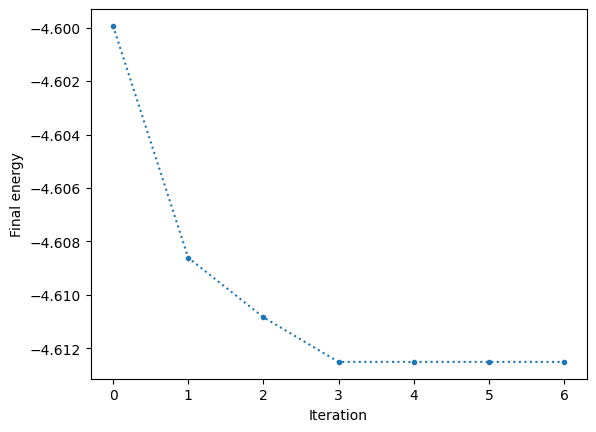

In [29]:
#| echo: false
#| label: fig-exit-energies
#| fig-cap: "Final minimized energies of each iteration" 
exit_energies = [history.energies[-1] for history in result.histories]
# plt.plot(exit_energies, )
fig, ax1 = plt.subplots()
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Final energy')
ax1.plot(exit_energies, marker='.', linestyle='dotted')
plt.show()

In [34]:
#| echo: false
#draw_circuit(final_circuit, 'fig-adapt-vqe-circuit', 'Final circuit of the ADAPT-VQE', width=500)

![Final circuit of the ADAPT-VQE](_build/fig-adapt-vqe-circuit.png){#fig-adapt-vqe-circuit width=100%}

The decreasing final energy of the molecule with the iterations of the adaptive solver is illustrated by @fig-exit-energies, where we also observe, that no meaningful progress is being made starting at iteration 3.

Comparing the resulting energy yields that the final energy is similar to the energy reached before, where we can observe that the energies are very similar, with the fixed-ansatz VQE reaching $E_{fixed} \approx -4.61250$, whereas the adaptive method reached $E_{adaptive} \approx -4.61251$.

# Conclusion and outlook

In this notebook, we explored the implementation of adaptive quantum algorithms in Tequila, a Python library for the development of quantum algorithms. 
Starting with an overview of the capabilities and functionalities of the Tequila library, we introduced the concepts of circuit construction and parametrization.
We have introduced the concept of adaptive quantum algorithms, and the basic concepts of quantum algorithms in general.
Furthermore, we have explored the implementation of a basic adaptive VQE, which allows us to construct the circuit ansatz adaptively, based on the problem to be solved.
In the final section, we have compared the adaptive VQE to the circuit depth of a VQE with a static ansatz.
The result is a significant reduction in circuit depth while reaching a similar value, which illustrates one key aspect of adaptive algorithms, to better use the available resources in NISQ-era quantum computers.
However, it is important to note that the advantage seen here is not universal and the choice of method or ansatz is still dependent on the problem to be optimized.

To summarize, we learned more about the state of quantum computing and the problems that can be solved by it.
With hands-on experience with the implementation VQEs and their adaptive methods, we acquired an overview of current problem-solving methods, and where these might still be lacking. One specific area that comes to mind is the automated choice of ansatz and whether or not to use adaptive methods. 
Furthermore, as we also encountered cases, where adaptive solving did not work with specific optimizers (most probably due to getting stuck at minima), there is also potential for automated criteria-based optimizer choices.

# Bibliography

::: {#refs}
:::